# Сжатие Аудиоданных

---

Аудиофайлы в несжатом формате `.wav` имеют огромный размер, например, 10,5 мегабайт в минуту. В настоящее время хранение данных стало недорогим, но такой объем данных все равно является **избыточным**. Поэтому мы стремимся сжать эти данные. Это можно сделать двумя способами:

1. **Сжатие без потерь** - форматы такие, как FLAC, ALAC и Monkey's Audio `.ape`. Идея заключается в том, что при сжатии и распаковке файла мы получаем исходное качество.

2. **Сжатие с потерями** - форматы такие, как MP3, Ogg и AAC `.m4a`. Они более популярны, но есть важный аспект: мы можем сильнее сжать файл, но при распаковке он уже не будет таким же.

Здесь стоит осознавать, что мы идем на компромисс: используя сжатие с потерями, мы теряем некоторую целостность полученного файла в пользу экономии памяти. Это приемлемо, особенно когда файлы занимают десятую часть пространства, а большинство не услышат разницы в качестве звука.

## Схема сжатия на основе PCA

---

Целью моей работы является применение метода главных компонент **PCA** для сжатия аудио. 

**PCA** широко используется в машинном обучении для снижения размерности данных. В простых терминах, идея состоит в том, чтобы найти способ представления данных, который соответствует оригиналу, но с меньшим количеством информации, аналогично сжатию данных. Хотя есть теоретические соображения, которые могут указывать на нежелательные результаты такого сжатия, я все же заинтересован в его исследовании.

Алгоритм **PCA** работает следующим образом: для набора данных с несколькими характеристиками, я ищу новые характеристики, которые статистически наиболее точно соответствуют оригинальным. 

В отношении аудио аналогично: у меня есть исходный аудио сигнал, и я хочу найти способ представления его, который будет приближенно соответствовать оригиналу. 
> NOTE: **PCA** разработан для статистических данных, а не для сигналов.

Идея заключается в следующем: 
1. Изменяем форму заданного сигнала на матрицу с 1000 столбцами и полученным соответственно числом строк.
2. Применяем алгоритм **PCA** и снижаем размерность с различными настройками. Количество главных компонент, которое я выбираю, определяет качество сжатия: 
   - Все 1000 компонент -> исходный сигнал. 
   - Меньшее количество компонент -> потеря части данных из оригинального сигнала

Это поможет мне проверить, возможно ли создать эффективную кодировочную схему на основе **PCA**.


## Реализация 

---

Для демонстрации процесса я буду использовать аудиосигнал **Beethoven Violin Sonata Op 96 first movement bars**. Для загрузки и обработки сигнала я импортирую следующие библиотеки:

In [1]:
# Для чтения и записи аудио файлов
from scipy.io import wavfile

# Для воспроизведения аудио
from IPython.display import Audio

# Для работы с данными
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

### Загрузка и воспроизведение аудио

---

Для начала загрузим аудиофайл:

In [2]:
samplerate, data = wavfile.read("data/Beethoven_Violin_Sonata_Op_96_first_movement_bars_1-22.wav")

print(f"Частота дискретизации: {samplerate} Гц")
print(f"Звуковые данные: {data.shape}")
print(f"Длина аудио: {len(data)/samplerate} секунд")

Частота дискретизации: 44100 Гц
Звуковые данные: (1990656, 2)
Длина аудио: 45.139591836734695 секунд


`samplerate` есть частота дискретизации - стандартное для аудио значние -- 44100 Гц.

> NOTE: **Частота дискретизации** говорит о том, сколько последовательных элементов массива с сигналом кодируют звук длительностью 1 секунда.

`data.shape` имеет два значения: `(n_samples, n_channels)`. Заметим, что звук - стерео, так как сигнал кодируется двумя каналами (для левого и правого динамика).

`len(data)/samplerate` -- длина аудио в секундах, которая вычисляется как отношение количества элементов массива к частоте дискретизации.



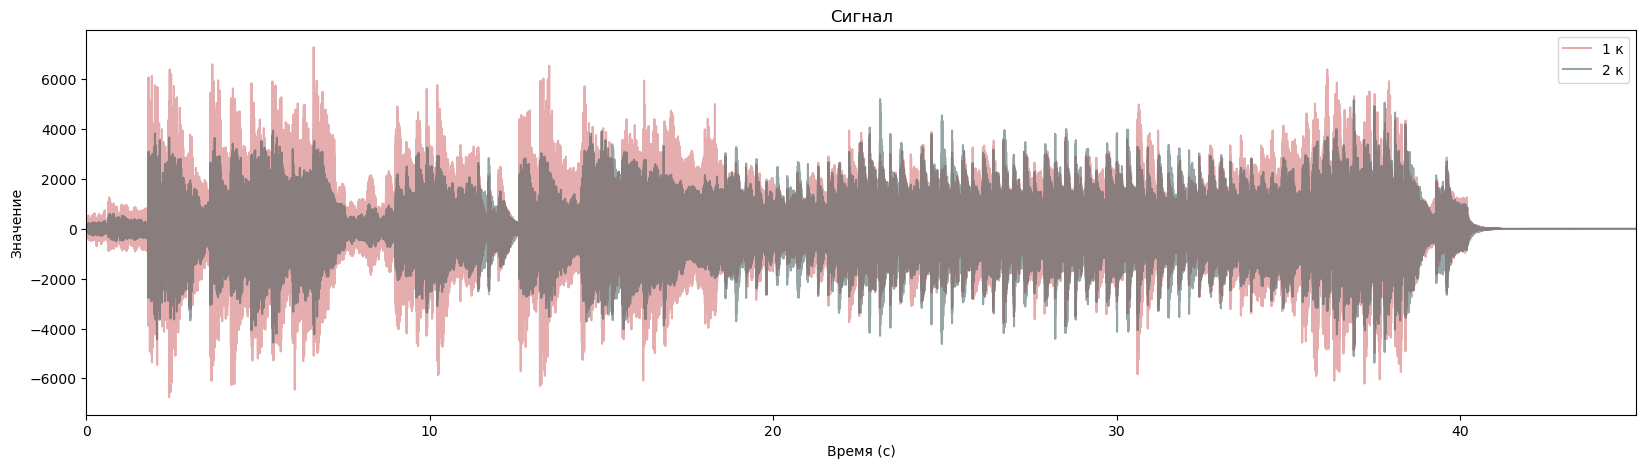

In [3]:
def plot_audio(data_: np.ndarray) -> None:
    colors_dct = {0: "indianred", 1: "darkslategrey", 2: "midnightblue"}
    
    plt.figure(figsize=(20, 5))

    sec_num = np.arange(data_.shape[0]) / samplerate
    for ind_ in range(data_.shape[1]):
        plt.plot(sec_num, data_[:, ind_], label=f"{ind_ + 1} к", alpha=0.5, c=colors_dct[ind_])
    plt.xlim(0, sec_num[-1])
    
    plt.title("Сигнал")
    plt.xlabel("Время (с)")
    plt.ylabel("Значение")
    plt.legend()

    plt.show()


plot_audio(data)

Чтобы воспроизвести аудио, мы должны выбрать один из каналов или объединить их в один. Усредним каналы для получения моно звука, с которым будет проще работать:

In [4]:
mono_sound = np.mean(data, axis=1)
print(mono_sound.shape)

(1990656,)


Теперь мы можем воспроизвести аудио, которое собрались сжимать:

In [5]:
Audio(mono_sound, rate=samplerate)

### Преобразование сигнала в матрицу

---

Для применения **PCA** преобразуем сигнал в матрицу, где каждый столбец представляет собой отдельный канал, а каждая строка - отдельный сэмпл. Таким образом, мы получим матрицу размера `(n_samples, n_channels)`. 

> NOTE: Для удобства - обрезаем массив с сигналом так, чтобы его было удобнее делить на равные части с длиной 1000.

Так как аудио сигнал теперь просто вектор, мы можем преобразовать его в матрицу с помощью `reshape`:

In [6]:
def reshape_sound(sound_array_: np.ndarray, n_samples_: int) -> tuple:
    n = len(sound_array_) // n_samples_
    cut_sound_array_ = sound_array_[:n * n_samples_]
    return cut_sound_array_, cut_sound_array_.reshape(-1, n_samples_)

mono_sound_matrix = reshape_sound(mono_sound, 1000)[1]
print(mono_sound_matrix.shape)

(1990, 1000)


### Обратное преобразование матрицы в сигнал

---

После сжатия сигнал, потребуется восстановить его обратно для проверки изменений в качестве. Применим обратное преобразование `reshape` и объединим каналы вместе:

In [7]:
def reshape_matrix(matrix_: np.ndarray) -> np.ndarray:
    return matrix_.reshape(-1)

restored_sound = reshape_matrix(mono_sound_matrix)
print(restored_sound.shape)

Audio(restored_sound, rate=samplerate)

(1990000,)


Звук идентичен оригиналу, что означает, что преобразование работает правильно.

### Применение PCA

---

Теперь мы можем применить **PCA** к матрице сигнала. Для этого используем библиотеку `sklearn`. 

Построим две главные компоненты в наглядной форме, чтобы сделать выводы исходя из их вида и попытаться уловить зависимости:

(1990, 2)


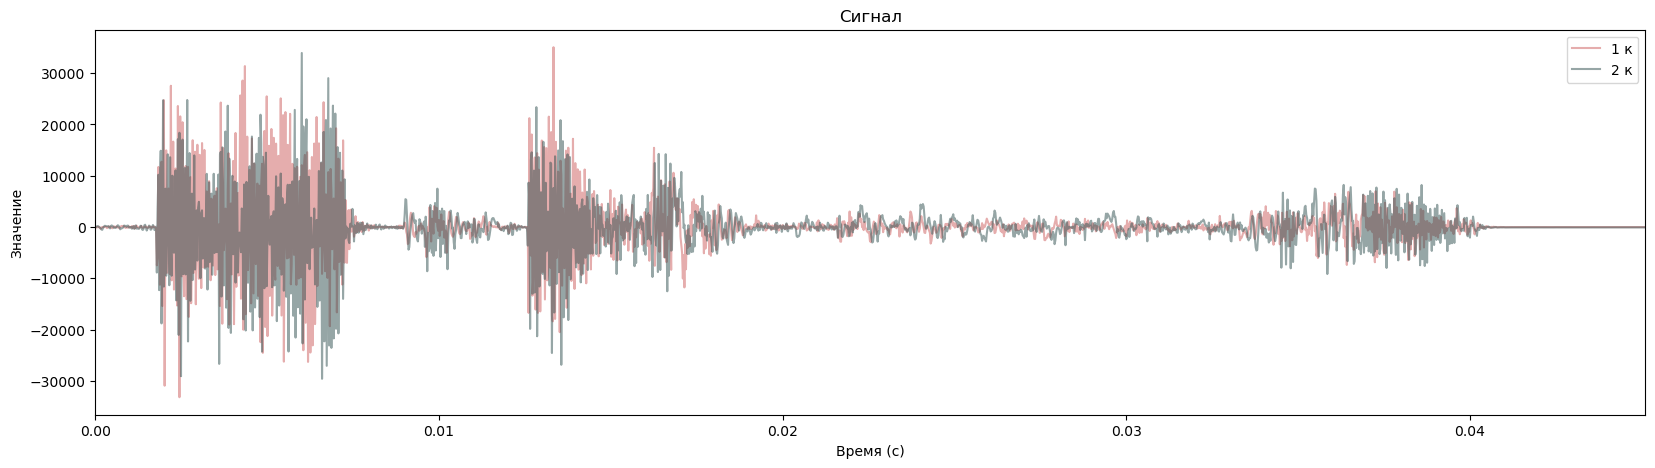

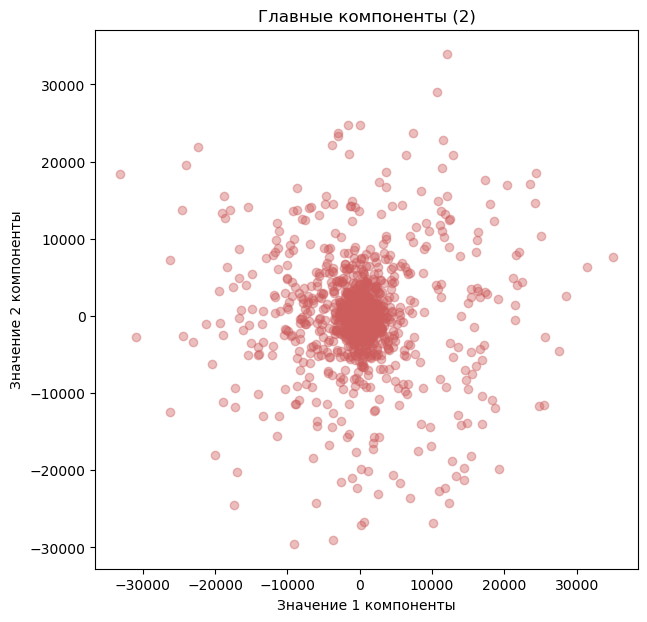

In [8]:
def plot_scatter(data_: np.ndarray) -> None:
    plt.figure(figsize=(7, 7))

    plt.scatter(data_[:, 0], data_[:, 1], alpha=0.4, c=data_[:, 2] if data_.shape[1] == 3 else "indianred")
    plt.xlabel("Значение 1 компоненты")
    plt.ylabel("Значение 2 компоненты")
    plt.title(f"Главные компоненты ({len(data_[0])})")

    plt.show()

def apply_pca(sound_array_: np.ndarray, n_components_: int, n_samples_: int = 1000) -> tuple:
    sound_array_, sound_matrix_ = reshape_sound(sound_array_, n_samples_)
    
    pca_ = PCA(n_components=n_components_)
    sound_matrix_pca_ = pca_.fit_transform(sound_matrix_)
    print(sound_matrix_pca_.shape)
    
    restored_sound_matrix = reshape_matrix(pca_.inverse_transform(sound_matrix_pca_))
    return sound_array_, sound_matrix_pca_, restored_sound_matrix
    

sound_matrix_pca_2 = apply_pca(mono_sound, 2)[1]
plot_audio(sound_matrix_pca_2)
plot_scatter(sound_matrix_pca_2)

Применим метод **PCA** уже с 3 компонентами и нарисуем тот же график, передав третью компоненту в качестве цвета:

(1990, 3)


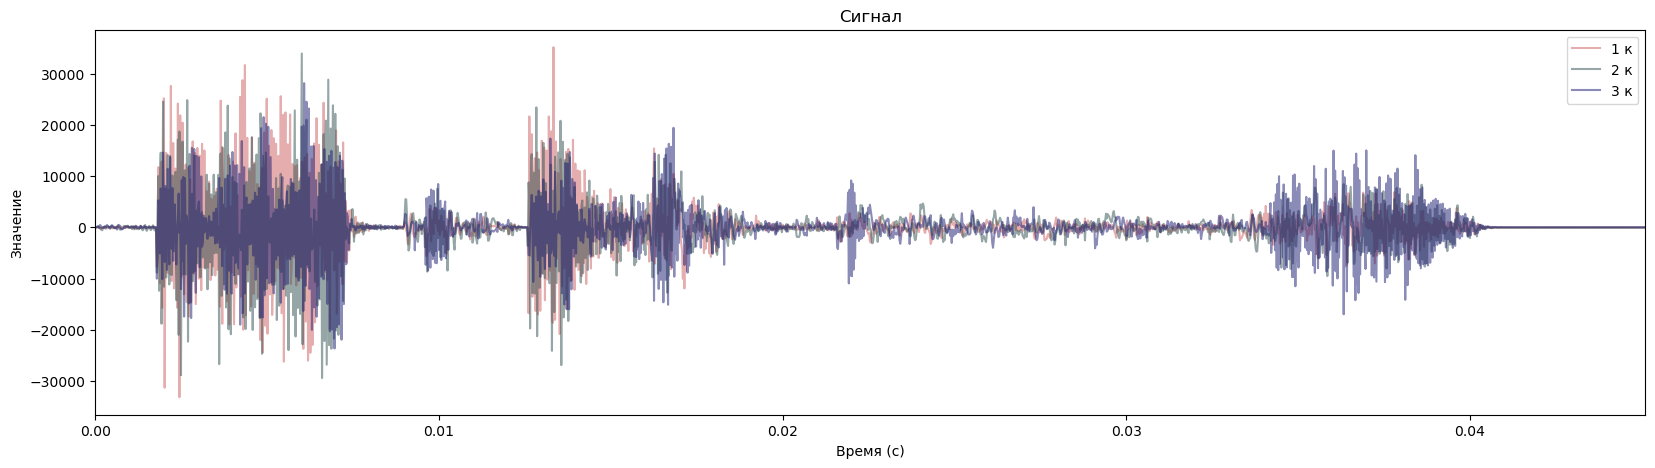

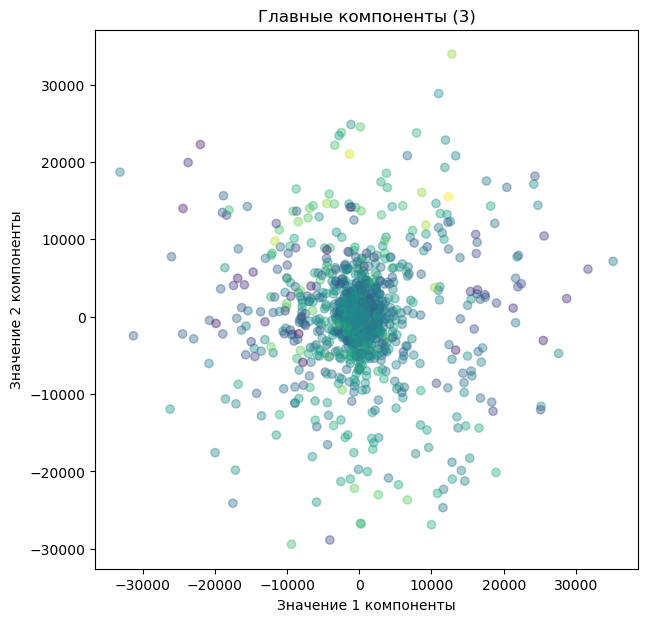

In [9]:
sound_matrix_pca_3 = apply_pca(mono_sound, 3)[1]
plot_audio(sound_matrix_pca_3)
plot_scatter(sound_matrix_pca_3)

### Сжатие сигнала

---

Исследуем зависимость качества звука от числа компонент. Подберем "на слух" минимальное число компонент, при котором звук практически не отличается от оригинала.

Отфильтруем сигнал с помощью функции `gaussian_filter1d` из `scipy.ndimage`. Это поможет убрать неприятный дробовой шум при сильном сжатии:

In [10]:
from scipy.ndimage import gaussian_filter1d


def check_quality_of_reconstruction(n_components_: int) -> Audio:
    mono_sound_matrix_, mono_sound_matrix_pca, restored_mono_sound_array = apply_pca(mono_sound, n_components_)
    print("Размерность сжатого звука:", mono_sound_matrix_pca.shape)
    print("Размерность восстановленного звука:", restored_mono_sound_array.shape)

    sec_num = np.arange(mono_sound_matrix_.shape[0]) / samplerate

    plt.figure(figsize=(20,5))
    plt.plot(sec_num, mono_sound_matrix_, c="darkslategrey", label="Оригинальный звук", alpha=0.6)
    plt.plot(sec_num, restored_mono_sound_array, c="indianred", label="Восстановленный звук", alpha=0.6)
    plt.xlim(0, len(sec_num) / samplerate)
    plt.title(f"Звук с {n_components_} компонентами")
    plt.xlabel("Время (с)")
    plt.ylabel("Значение")
    plt.show()

    diff = np.abs(mono_sound_matrix_ - restored_mono_sound_array)
    plt.figure(figsize=(10, 10))
    plt.scatter(mono_sound_matrix_, restored_mono_sound_array, c=diff, cmap=plt.colormaps.get_cmap("Paired"), alpha=0.4)
    
    plt.plot(mono_sound_matrix_ * 1.1, mono_sound_matrix_ * 1.1, c="red", alpha=0.5)
    plt.title(f"Отклонение от оригинала с {n_components_} компонентами")
    plt.xlabel("Оригинальный звук")
    plt.ylabel("Восстановленный звук")
    plt.text(0.1, 0.9, f"Среднее отклонение: {np.mean(diff):.2f}", transform=plt.gca().transAxes)
    plt.colorbar()
    plt.show()

    return Audio(gaussian_filter1d(restored_mono_sound_array, 2), rate=samplerate)

#### Оригинальный звук


---

(1990, 1000)
Размерность сжатого звука: (1990, 1000)
Размерность восстановленного звука: (1990000,)


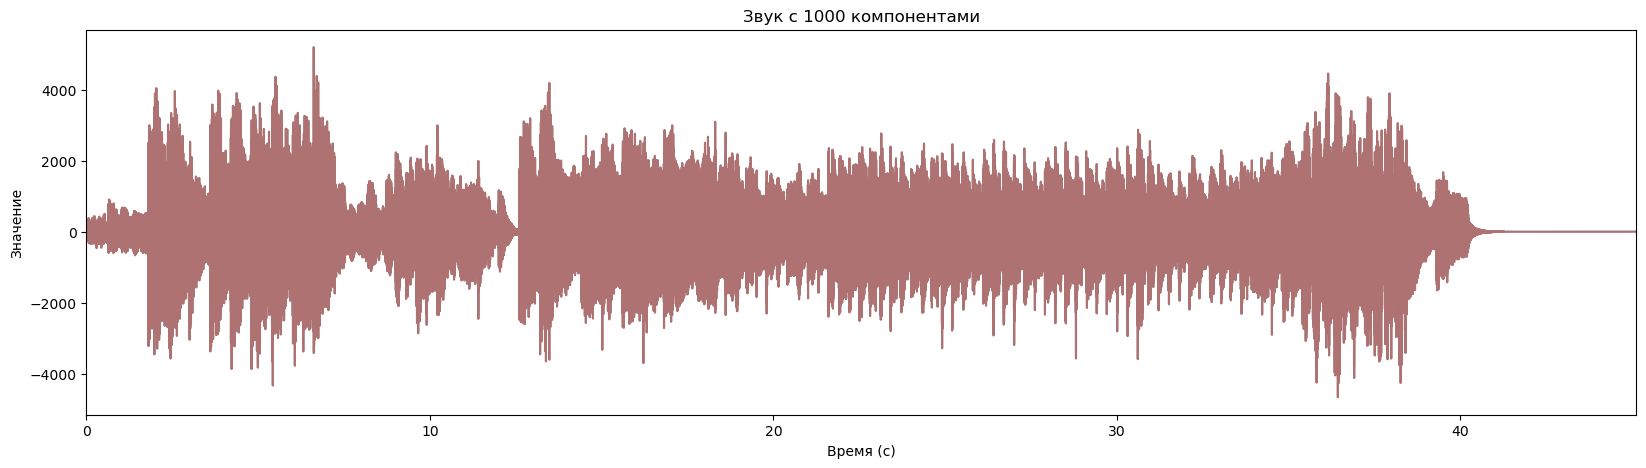

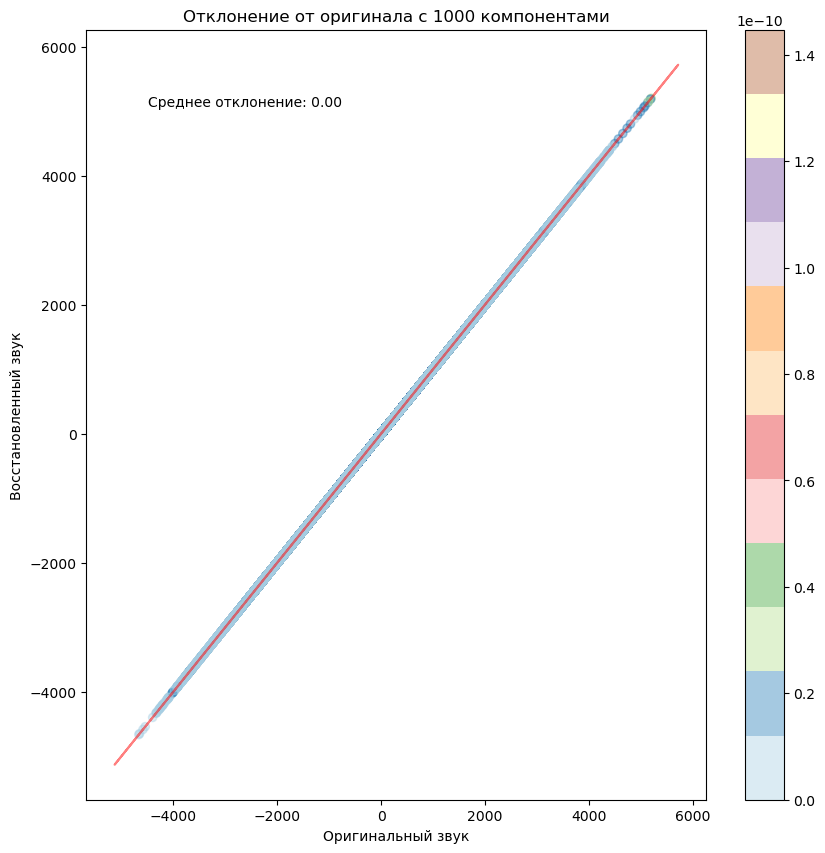

In [11]:
check_quality_of_reconstruction(1000)

Как и ожидалось, звук идентичен оригиналу (отклонение от оригинала - 0.00).

#### Сжатие с 10 компонентами

---

(1990, 10)
Размерность сжатого звука: (1990, 10)
Размерность восстановленного звука: (1990000,)


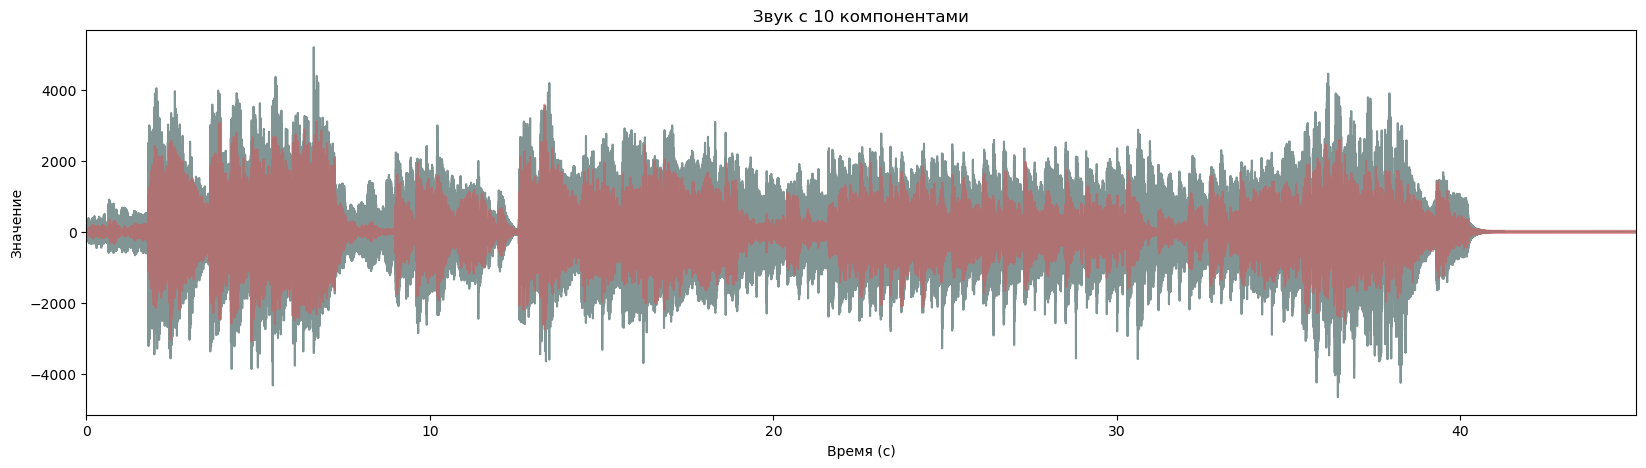

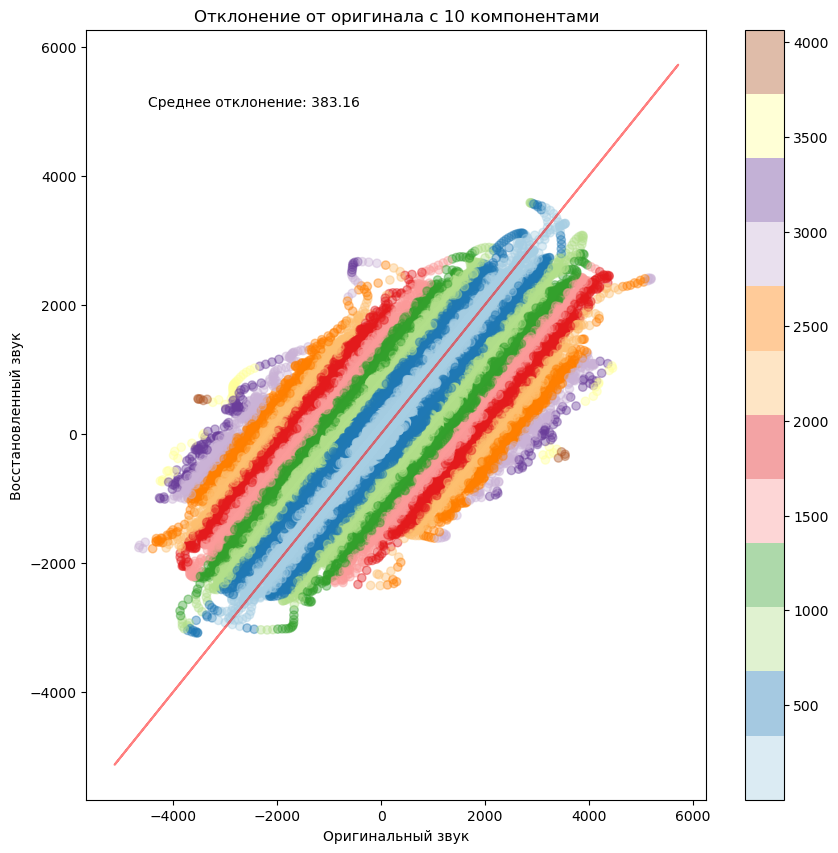

In [12]:
check_quality_of_reconstruction(10)

Это звучит ужасно, и с трудом можно узнать оригинальный сигнал (отклонение от оригинала - 383.12).

#### Углубление понимания процесса

---

Алгоритм **PCA** стремится найти оптимальное представление набора данных с помощью компонент. Каждая компонента содержит информацию, необходимую для восстановления полного аудио. Например, может быть низкочастотная компонента, содержащая информацию о басовой линии, а также другие компоненты, объясняющие высокочастотные аспекты, такие как вокал или мелодии.

Одним из интересных аспектов **PCA** является его попытка найти наиболее значимые компоненты для объяснения сигнала. В области обработки сигналов это означает, что **PCA** ищет сигналы в данных, отделяя их от шума. В нашем случае это означает, что **PCA**, работая с ограниченным числом компонент, в первую очередь удаляет шумные компоненты. Он старается восстановить сигнал, но при этом приходится делать некоторые компромиссы.

Таким образом, говоря, что **PCA** определяет шумные компоненты в данных, можно интерпретировать как удаление высокочастотных компонент: низкочастотный сигнал легко восстанавливается, в то время как высокочастотный сигнал сложнее представить, так как он меняется очень быстро. Когда **PCA** работает с ограниченным числом компонент, он старается воспроизвести низкочастотные аспекты и при этом может пропустить высокочастотные.

#### Сжатие с 50 компонентами

---

(1990, 50)
Размерность сжатого звука: (1990, 50)
Размерность восстановленного звука: (1990000,)


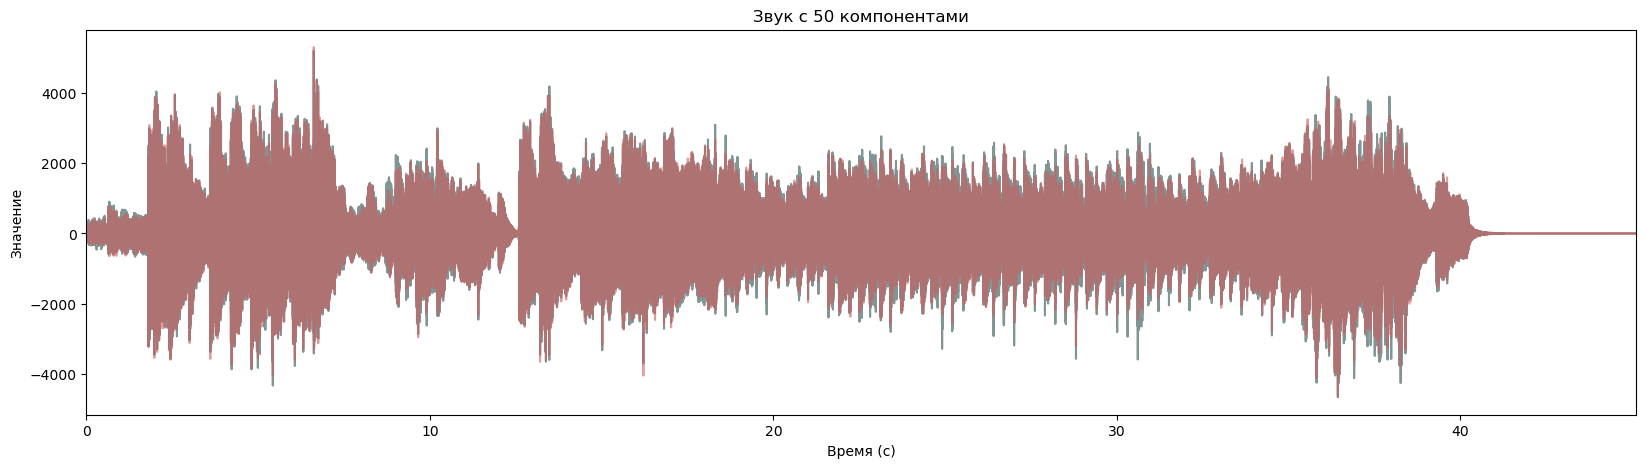

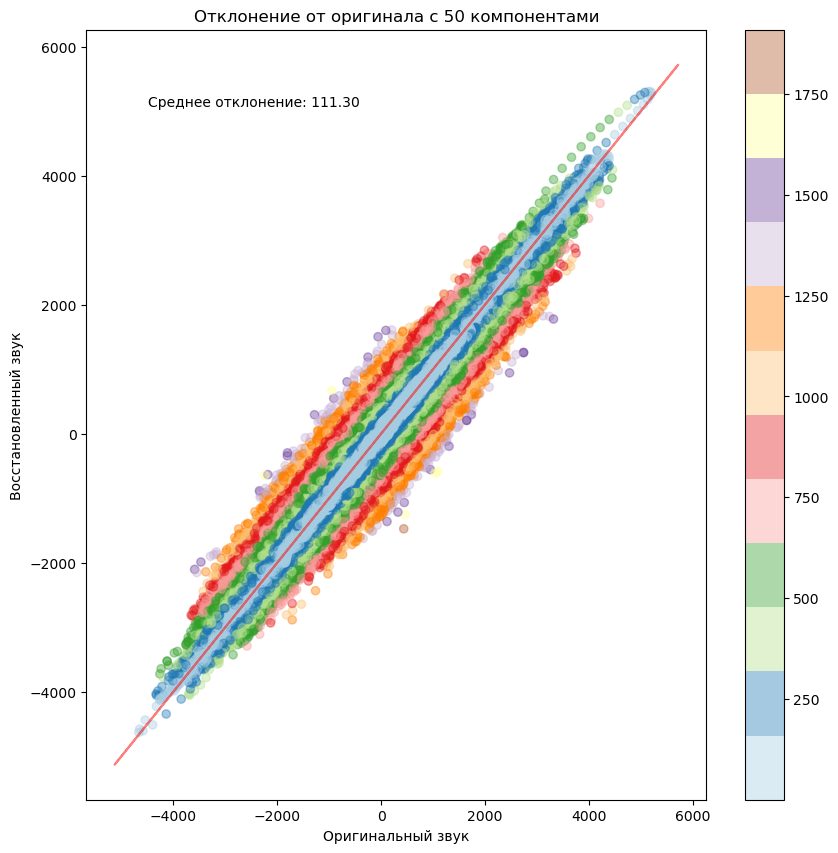

In [13]:
check_quality_of_reconstruction(50)

Увеличение числа компонент в 5 раз улучшило качество звука, но все еще далеко от оригинала (отклонение от оригинала - 111.30).

#### Сжатие с 100 компонентами

---

(1990, 100)
Размерность сжатого звука: (1990, 100)
Размерность восстановленного звука: (1990000,)


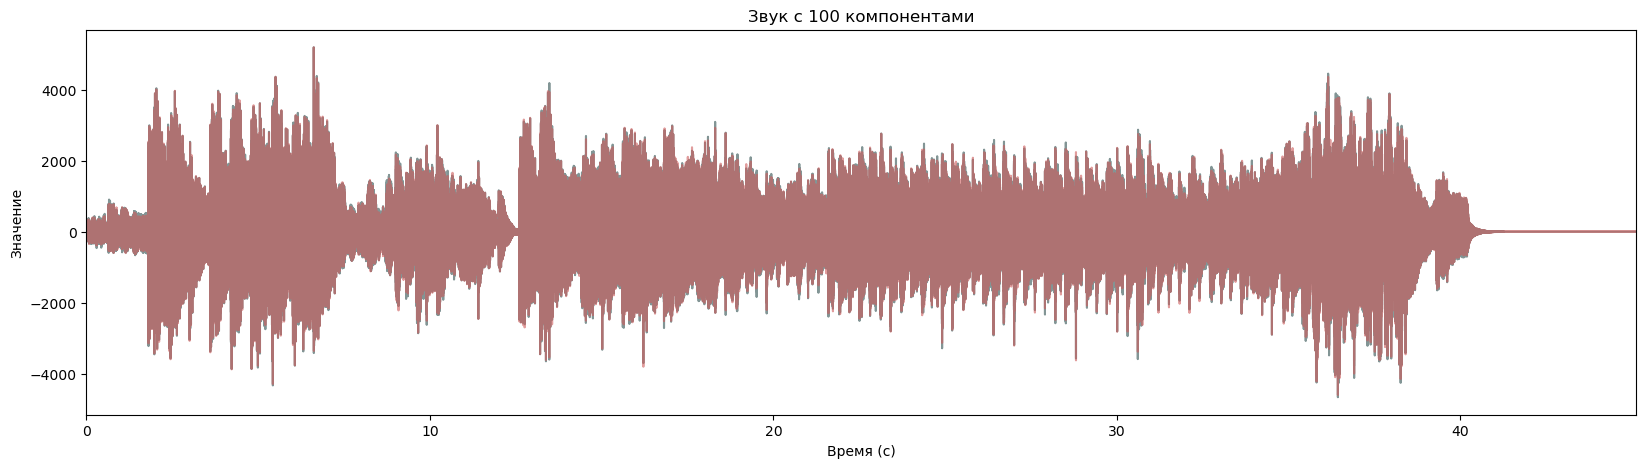

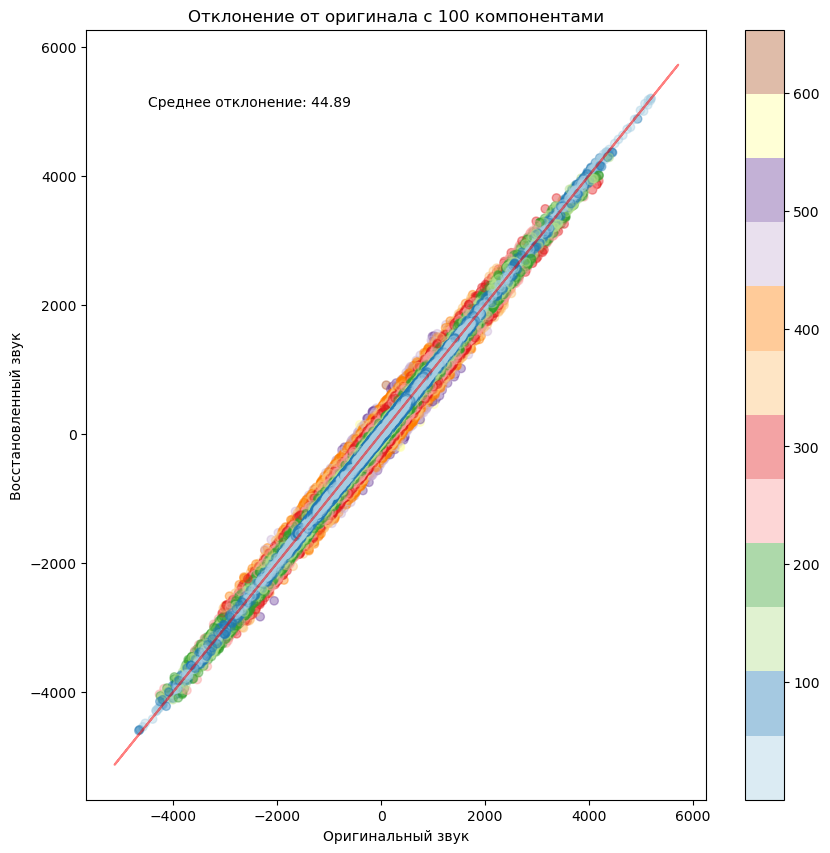

In [14]:
check_quality_of_reconstruction(100)

Качество звука улучшилось, но все еще далеко от оригинала (отклонение от оригинала - 44.90). Основная проблема в возникновении шума, который мы можем увидеть на графике отклонения от оригинала.

Может уйти много времени на подбор числа компонент, которое даст хороший результат. Попробуем сделать выводы на основе анализа предыдущих результатов.

#### Оптимальное число компонент

---

Использование большого количества компонентов позволяет достичь звука, который очень близок к оригиналу, а малое количество компонентов действует как фильтр низких частот. Однако, для определения оптимального размера кодирования, нам необходимо иметь **эталон**, который мы сможем использовать в качестве меры качества звука.

1. Для этого мы попробовали использовать самих себя, выступая в качестве судьи качества звука. Такой подход не очень хорош, так как мы не можем объективно оценить качество звука. Да и времени на подбор оптимального числа компонент уйдет много.

2. Мы можем создать дополнительную функцию, которая поможет нам оценить, сколько места нам нужно для хранения данных. Эта функция будет основываться на сравнении звукового сигнала, полученного с использованием разного числа компонентов, с оригинальным сигналом. Я буду использовать среднее отклонение **MAE** для оценки качества воспроизведения. Так же, для сравнения рассмотрим среднеквадратическое отклонение **RMSE** или структурное сходство **SSIM** и его модификацию **DSSIM**.

3. Посчитать отношение размеров сжатого и оригинального файла. Отношения полученного значения к **MAE** и **MAE** к размеру сжатого файла.

> NOTE: **MAE** и **RMSE** - это меры расстояния между двумя векторами. **SSIM** - это мера сходства (**DSSIM** - различия) между двумя изображениями, которую я попробую применить к звуковым сигналам.

Таким образом, мы сможем определить, какое количество компонентов достаточно для достижения "достаточно хорошего" качества звука, и использовать эту информацию для определения оптимального размера кодирования.

Точкой остановки обозначим момент, когда изменение качества звука станет незначительным. Для этого будем сравнивать качество звука с предыдущим значением и останавливать процесс, когда изменение станет меньше **0.1**.

In [15]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error


def ssim(arr1: np.ndarray, arr2: np.ndarray) -> float:
    mean_arr1, mean_arr2 = np.mean(arr1), np.mean(arr2)
    var_arr1, var_arr2 = np.var(arr1), np.var(arr2)
    cov = np.mean((arr1 - mean_arr1) * (arr2 - mean_arr2))
    k1, k2 = 0.01, 0.03
    L = 2**16 - 1
    c1, c2 = (k1 * L)**2, (k2 * L)**2
    return (2 * mean_arr1 * mean_arr2 + c1) * (2 * cov + c2) / ((mean_arr1 ** 2 + mean_arr2 ** 2 + c1) * (var_arr1 + var_arr2 + c2))

def dssim(arr1: np.ndarray, arr2: np.ndarray) -> float:
    return (1 - ssim(arr1, arr2)) / 2

def compare_file_sizes(original_: np.ndarray, compressed_: np.ndarray) -> float:
    original_size_ = original_.tobytes().__sizeof__() / 2
    compressed_size_ = compressed_.tobytes().__sizeof__() / 2
    return compressed_size_ / original_size_

def get_quality_of_reconstruction(n_components_: int) -> tuple:
    mono_sound_matrix_, mono_sound_matrix_pca, restored_mono_sound_array = apply_pca(mono_sound, n_components_)
    mae_ = mean_absolute_error(mono_sound_matrix_, restored_mono_sound_array)
    rmse_ = mean_squared_error(mono_sound_matrix_, restored_mono_sound_array)
    ssim_ = ssim(mono_sound_matrix_, restored_mono_sound_array)
    dssim_ = dssim(mono_sound_matrix_, restored_mono_sound_array)
    weight_ = compare_file_sizes(mono_sound_matrix, mono_sound_matrix_pca)
    weight_per_mae_ = weight_ / mae_
    mae_on_weight_ = mae_ * weight_
    return n_components_, mae_, rmse_, ssim_, dssim_, weight_, weight_per_mae_, mae_on_weight_

metrics_lst = []
for n in range(1, mono_sound_matrix.shape[1]):
    metrics_lst.append(get_quality_of_reconstruction(n))
    if (len(metrics_lst) >= 2) and (metrics_lst[-2][1] - metrics_lst[-1][1] < 0.1):
        break

columns = ["n_components", "mae", "rmse", "ssim", "dssim", "weight", "weight_per_mae", "mae_on_weight"]
df_result = pd.DataFrame(columns=columns, data=metrics_lst)
df_result.head()

(1990, 1)
(1990, 2)
(1990, 3)
(1990, 4)
(1990, 5)
(1990, 6)
(1990, 7)
(1990, 8)
(1990, 9)
(1990, 10)
(1990, 11)
(1990, 12)
(1990, 13)
(1990, 14)
(1990, 15)
(1990, 16)
(1990, 17)
(1990, 18)
(1990, 19)
(1990, 20)
(1990, 21)
(1990, 22)
(1990, 23)
(1990, 24)
(1990, 25)
(1990, 26)
(1990, 27)
(1990, 28)
(1990, 29)
(1990, 30)
(1990, 31)
(1990, 32)
(1990, 33)
(1990, 34)
(1990, 35)
(1990, 36)
(1990, 37)
(1990, 38)
(1990, 39)
(1990, 40)
(1990, 41)
(1990, 42)
(1990, 43)
(1990, 44)
(1990, 45)
(1990, 46)
(1990, 47)
(1990, 48)
(1990, 49)
(1990, 50)
(1990, 51)
(1990, 52)
(1990, 53)
(1990, 54)
(1990, 55)
(1990, 56)
(1990, 57)
(1990, 58)
(1990, 59)
(1990, 60)
(1990, 61)
(1990, 62)
(1990, 63)
(1990, 64)
(1990, 65)
(1990, 66)
(1990, 67)
(1990, 68)
(1990, 69)
(1990, 70)
(1990, 71)
(1990, 72)
(1990, 73)
(1990, 74)
(1990, 75)
(1990, 76)
(1990, 77)
(1990, 78)
(1990, 79)
(1990, 80)
(1990, 81)
(1990, 82)
(1990, 83)
(1990, 84)
(1990, 85)
(1990, 86)
(1990, 87)
(1990, 88)
(1990, 89)
(1990, 90)
(1990, 91)
(1990, 9

,n_components,mae,rmse,ssim,dssim,weight,weight_per_mae,mae_on_weight
0,1,491.829640,474564.793572,0.892080,0.053960,0.001002,0.000002,0.492848
1,2,478.360647,446437.860254,0.899122,0.050439,0.002002,0.000004,0.957711
2,3,466.539556,423657.349214,0.904760,0.047620,0.003002,0.000006,1.400583
3,4,455.165927,401699.909335,0.910139,0.044930,0.004002,0.000009,1.821603
4,5,442.723485,380672.838598,0.915242,0.042379,0.005002,0.000011,2.214531


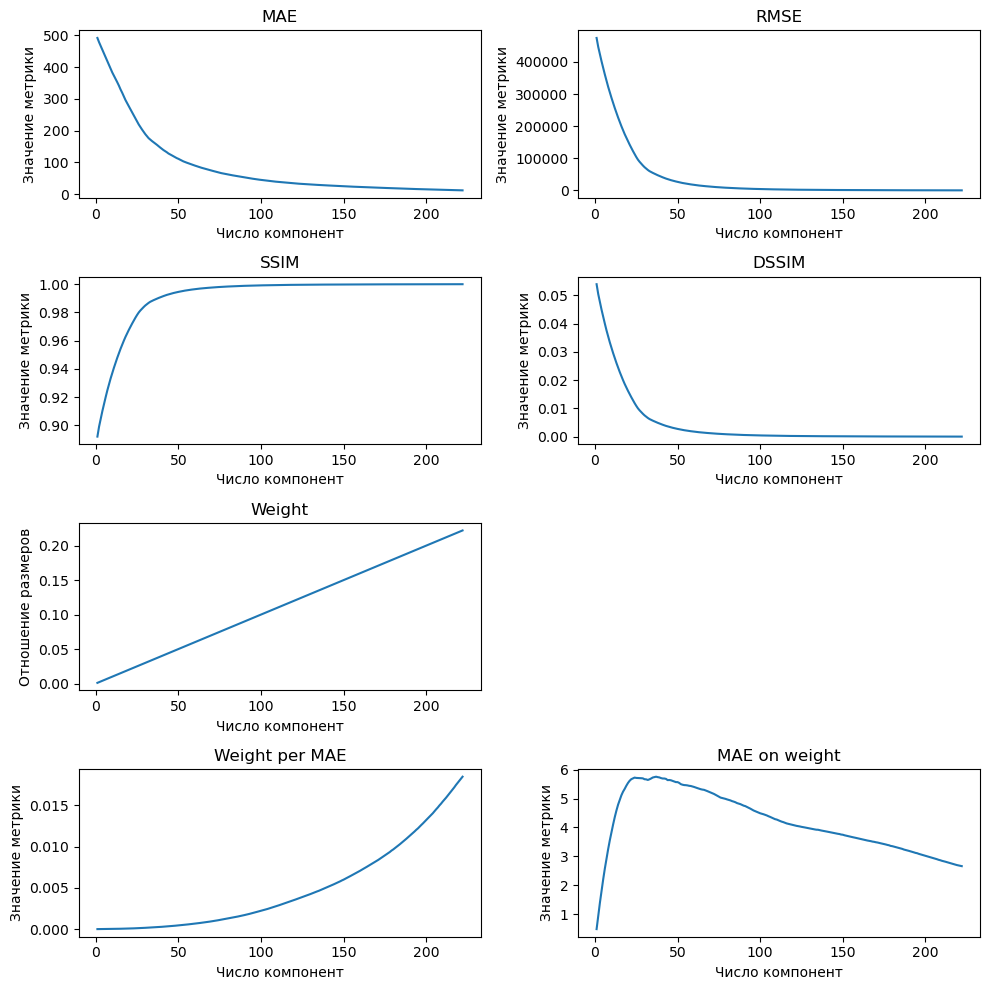

In [16]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(10, 10))

ax1.plot(df_result["n_components"], df_result["mae"], label="MAE")
ax1.set_title("MAE")
ax1.set_xlabel("Число компонент")
ax1.set_ylabel("Значение метрики")

ax2.plot(df_result["n_components"], df_result["rmse"], label="RMSE")
ax2.set_title("RMSE")
ax2.set_xlabel("Число компонент")
ax2.set_ylabel("Значение метрики")

ax3.plot(df_result["n_components"], df_result["ssim"], label="SSIM")
ax3.set_title("SSIM")
ax3.set_xlabel("Число компонент")
ax3.set_ylabel("Значение метрики")

ax4.plot(df_result["n_components"], df_result["dssim"], label="DSSIM")
ax4.set_title("DSSIM")
ax4.set_xlabel("Число компонент")
ax4.set_ylabel("Значение метрики")

ax5.plot(df_result["n_components"], df_result["weight"], label="Weight")
ax5.set_title("Weight")
ax5.set_xlabel("Число компонент")
ax5.set_ylabel("Отношение размеров")

ax6.set_visible(False)

ax7.plot(df_result["n_components"], df_result["weight_per_mae"], label="Weight per MAE")
ax7.set_title("Weight per MAE")
ax7.set_xlabel("Число компонент")
ax7.set_ylabel("Значение метрики")

ax8.plot(df_result["n_components"], df_result["mae_on_weight"], label="MAE on weight")
ax8.set_title("MAE on weight")
ax8.set_xlabel("Число компонент")
ax8.set_ylabel("Значение метрики")

plt.tight_layout()
plt.show()

Из графиков видно, что все метрики кроме **MAE** показывают быстрое улучшение качества звука при увеличении числа компонент (_~40_). **MAE** показывает, что качество звука улучшается медленно, но стабильно и более плавно. Однако, даже на графике **MAE** видно, что качество звука улучшается медленнее после _~40_ компонент. 

И масла в огонь подливает линейная зависимость между числом компонент и размером сжатого файла. С каждой добавленной компонентой, размер сжатого файла увеличивается на 7 960 байт. Это означает, что для оригинального файла размером _7 960 000 байт_, мы можем сжать файл в 10 раз, используя 100 компонент, в 5 раз, используя 200 компонент, и т.д. То есть каждые 100 компонент увеличивают размер сжатого файла в 10 раз. Взглянув на график **MAE on weight**, мы можем увидеть, что максимальная полезность сжатия достигается при _~40_ компонентах. После этого, сжатие, практически линейно, становится все менее эффективным.

In [17]:
df_result.iloc[30:50]

,n_components,mae,rmse,ssim,dssim,weight,weight_per_mae,mae_on_weight
30,31,182.588733,68065.637376,0.985831,0.007084,0.031002,0.000170,5.660617
31,32,176.237147,63798.318607,0.986731,0.006634,0.032002,0.000182,5.639942
32,33,171.573450,60144.722577,0.987501,0.006250,0.033002,0.000192,5.662268
33,34,167.373433,57307.859905,0.988097,0.005951,0.034002,0.000203,5.691032
34,35,163.562289,54690.495689,0.988647,0.005677,0.035002,0.000214,5.725007
35,36,159.443628,52143.476226,0.989181,0.005409,0.036002,0.000226,5.740289
36,37,155.460938,49669.983124,0.989700,0.005150,0.037002,0.000238,5.752365
37,38,150.973995,47365.260880,0.990183,0.004909,0.038002,0.000252,5.737313
38,39,146.844601,45107.142198,0.990655,0.004673,0.039002,0.000266,5.727232
39,40,142.599477,42956.235169,0.991105,0.004448,0.040002,0.000281,5.704263


Можем предположить, что минимальное число компонент, при котором качество звука будет хоть сколько-нибудь приемлемым, будет равно 40. После данного значения происходит линейное ухудшение отношения прироста в качестве к приросту в размере сжатого файла. 

Теперь разберем то количество компонент, которое было выбрано как оптимальное - наш алгоритм остановился на 222. Проверим качество звука при таком числе компонент:

(1990, 230)
Размерность сжатого звука: (1990, 230)
Размерность восстановленного звука: (1990000,)


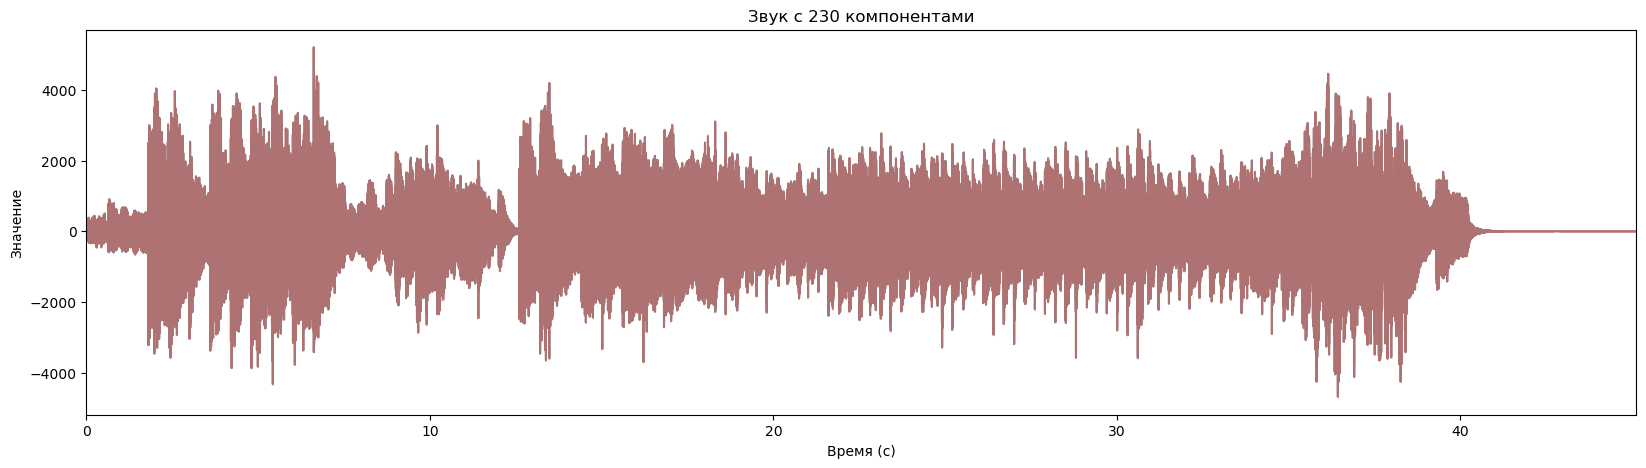

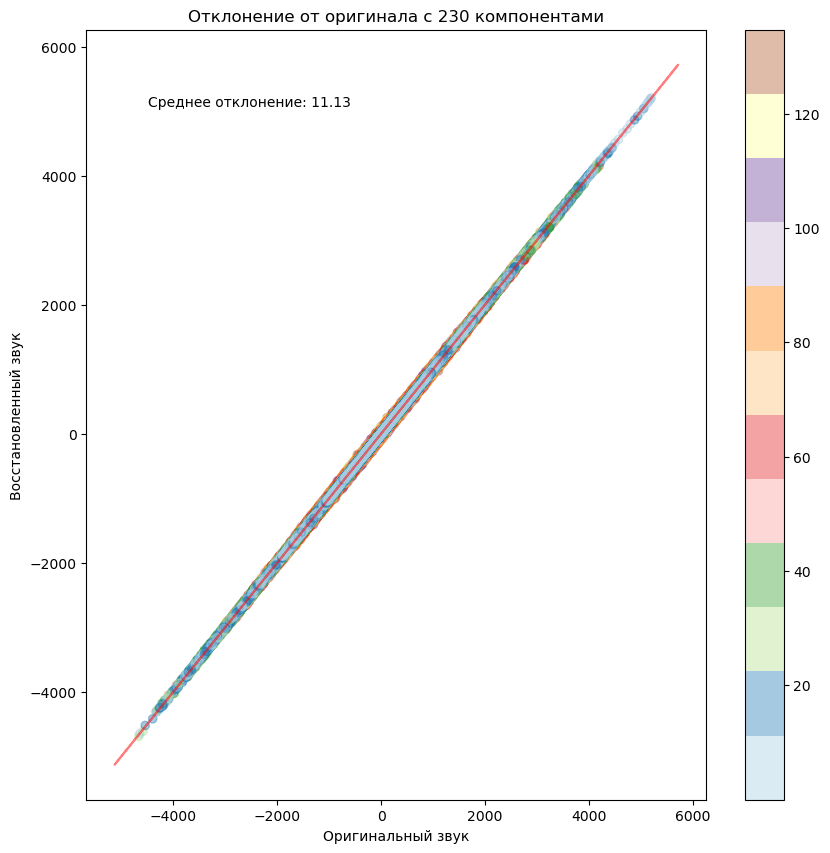

In [18]:
check_quality_of_reconstruction(222)

Действительно, качество звука улучшилось. Мы можем сказать, что оно приближается к оригиналу (отклонение от оригинала - 11.13). При этом замечу, что вместо 1000 компонент мы используем 222, что в _~4.5_ раза меньше. Таким образом, мы смогли сжать аудио в _~4.5_ раза, при этом потеряв незначительное (для большинства неуловимое) качество звука.

Степень сжатия в задаче сжатия звука отвечает за количество компонент, которые используются для представления звуковых данных. Это значение можно автоматически подобрать с помощью различных методов оценки качества восстановления или минимизации ошибки сжатия. Влияние степени сжатия на звук заключается в том, что с увеличением числа компонент (уменьшение степени сжатия) улучшается и точность восстановления звука, а с уменьшением числа компонент (увеличение степени сжатия) точность восстановления ухудшается. Это происходит потому, что более высокие частоты и более мелкие детали могут быть потеряны при использовании меньшего числа компонент.


#### Означает ли это, что данные результаты можно применить для описания сжатия любого аудио? 

---

Для каждой звуковой дорожки требуется индивидуальный подбор числа компонент. Один из способов автоматического подбора числа компонент - использование методов оценки качества восстановления или минимизации ошибки сжатия. Можно вычислить ошибку при различных значениях числа компонент и выбрать то значение, при котором будет наибольшим отношение размера получаемого сжатия файла к этой ошибке.

Для большой аудиозаписи лучше разбивать на большее число отрезков по сравнению с предложенной аудиозаписью. Это объясняется тем, что большая аудиозапись, вероятно, содержит больше различных звуков и акустических особенностей, которые могут быть представлены во временной и частотной областях. Поэтому, чтобы более полно учесть специфические особенности большой аудиозаписи, требуется использовать большее число отрезков.



## Выводы

---

Что я думаю о применении PCA для сжатия звука?

Удивительно, но этот метод действительно работает достаточно хорошо, в отличие от моих ожиданий. Тем не менее, в целом, это неудачная идея.

1. Эта техника не позволяет сэкономить место. Матрица компонентов, необходимая для применения алгоритма PCA, сама по себе занимает много места, поэтому добиться экономии без потери качества звука достаточно сложно. Более того, современные кодеки, такие как AAC, имеют отличное качество звучания даже при низких битрейтах, о которых метод PCA мог только мечтать.

2. Возникают проблемы с передачей звука в режиме потоковой передачи. PCA требует двух компонентов: потока данных и матрицы для восстановления исходного сигнала. Если передача данных в потоке осуществима, то передача матрицы становится проблематичной. Даже если разделить поток на небольшие блоки для получения меньшей матрицы, необходимо гарантировать наличие этой матрицы, иначе поток данных становится бессмысленным.

В общем, это был хороший эксперимент. Интересно видеть, как PCA применяется для анализа сигналов в неожиданных областях!